<a href="https://colab.research.google.com/github/JayThibs/WIP-Machine-Learning-Web-Apps/blob/master/Automated-Medical-Diagnosis/Detection_of_Pneumonia_from_Chest_X_Ray_Images_1_0_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Summary
<pre>
Author           : Jacques Thibodeau
Project Name     : Detection of Pneumonia from Chest X-Ray Images using Convolutional Neural Network, and Transfer Learning.
Description      : 1. Detected Pneumonia from Chest X-Ray images using Custom Deep Convololutional Neural Network 
                      and by retraining pretrained model “InceptionV3” with 5856 images of X-ray (1.15GB).
                   2. For retraining removed output layers, freezed first few layers and fine-tuned model for two 
                      new label classes (Pneumonia and Normal).
                   3. With Custom Deep Convololutional Neural Network attained testing accuracy 89.53% and loss 0.41.
Method           : 
Tools/Library    : Python, Keras, PyTorch, TensorFlow
Version History  : 1.0.0.0
Current Version  : 1.0.0.0
Last Update      : 16.Sept.2019
Comments         : 
</pre>

#### Code
<pre>
GitHub Link      : <a href=https://github.com/JayThibs/Machine-Learning-Web-Apps/blob/master/Automated-Medical-Diagnosis/Detection_of_Pneumonia_from_Chest_X_Ray_Images_1_0_0_0.ipynb>Detection of Pneumonia from Chest X-Ray Images(GitHub)</a>
Portfolio        : <a href=www.jacquesthibodeau.com/portfolio/>Jacques Thibodeau's Portfolio</a>
</pre>

---

# Problem Statement

The goal is to use transfer learning with the InceptionV3 model on a set of X-Ray Images of patients test in order to predict whether the patient has pneumonia or not.

# 0. References

## 0.1 Project Help



*   This project has been based partially on a paper implementation <a href=https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning/blob/master/code/Detection%20of%20Pneumonia%20from%20Chest%20X-Ray%20Images%201.0.0.3.ipynbhere>here</a> by Github User, <a href=https://github.com/anjanatiha/>anjanatiha</a>
*   Original Paper   : <a href=https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5>Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning</a>
                   (Daniel S. Kermany, Michael Goldbaum, Wenjia Cai, M. Anthony Lewis, Huimin Xia, Kang Zhang)
                   https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## 0.2 The Pneumonia Dataset

<pre>
Dataset Name     : Chest X-Ray Images (Pneumonia)
Dataset Link     : <a href=https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia>Chest X-Ray Images (Pneumonia) Dataset (Kaggle)</a>
                 : <a href=https://data.mendeley.com/datasets/rscbjbr9sj/2>Chest X-Ray Images (Pneumonia) Dataset (Original Dataset)</a>
</pre>

---

# 1. Import Libraries

In [1]:
!pip install tensorflow-gpu==1.14.0rc1

     |████████████████████████████████| 377.0MB 53kB/s 
     |████████████████████████████████| 3.2MB 30.0MB/s 
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 1.13.1 which is incompatible.
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0


In [0]:
import os # for reading from the file
import math # for any kind of data preprocessing
import json # for reading data

import sys # System-Specific parameters and functions
# The sys module is a set of functions which provide crucial information about 
# how your Python script is interacting with the host system.

import argparse
# The argparse module makes it easy to write user-friendly command-line 
# interfaces. The program defines what arguments it requires, and 
# argparse will figure out how to parse those out of sys.argv.

RANDOM_SEED=42
import random

import time
import datetime

from collections import Counter

import shutil
from tqdm import tqdm

import urllib.request

import inspect
import gc

import re

from PIL import Image
import cv2

from IPython.display import display

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.python.keras import utils as np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout 
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial

from mlxtend.plotting import plot_confusion_matrix

import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

*enable_eager_exection*: there are two types of machine learning

1.   Define **by** Run (PyTorch): THE GOOD WAY TO BUILD MODELS. Faster, dynamic, more resilient, easier to train, and faster to train. It performs operations as you create them instead of waiting until compile time.
2.   Define **and** Run (Keras)

PyTorch was the framework that made Define **by** Run popular. TensorFlow is not Define **and** Run by default, but you can use tf.enable_eager_execution() to make it use Define **by** Run.

Eager Execution is particularly important when we are doing transfer learning.

AUTOTUNE makes the model train faster.

Optimizing Performance not only involves making the model train as fast as possible but also making the data pipeline as fast as possible. Without pipelining, the CPU and the GPU/TPU sit idle for much of the time. The idle time is cut significantly with pipelining. We use AUTOTUNE to make sure the batch process happens as fast as possible.

# 2. Exploring Dataset

In [0]:
!rm -rf chest-xray-pneumonia

In [23]:
os.environ['KAGGLE_USERNAME'] = "jacquesthibodeau"
os.environ['KAGGLE_KEY'] = "705366c3d0eab86e85cc5c5cf45af3fb"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:16<00:00, 164MB/s]
100% 2.29G/2.29G [00:16<00:00, 150MB/s]


In [24]:
!unzip /content/chest-xray-pneumonia.zip -d chest-xray-pneumonia

Archive:  /content/chest-xray-pneumonia.zip
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/._chest_xray  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: c

In [0]:
!rm -rf chest-xray-pneumonia.zip
!rm -rf chest-xray-pneumonia/chest_xray/__MACOSX
!rm -rf chest-xray-pneumonia/chest_xray/chest_xray

In [0]:
# Creates directory if directory exists 
# removes directory (to create new one) if remove parameter is set to True
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

In [0]:
#@title Default title text
# print date and time for given type of representation
def date_time(x):
  if x==1:
      return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
  if x==2:    
      return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
  if x==3:  
      return 'Date now: %s' % datetime.datetime.now()
  if x==4:  
      return 'Date today: %s' % datetime.date.today()

In [0]:
# prints an integer for debugging
def debug(x):
  print("-"*40, x, "-"*40)

In [0]:
# Removes everything except alphabetical and 
# selected characters from name string
def name_correct(name):
  return re.sub(r'[a-zA-Z,:', ' ', name).title()

### Data Visualization Function

In [0]:
def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", 
                          legends=[], title_fontsize=18, label_fontsize=14, 
                          image_file_name="", save=False, dpi=100, 
                          update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

In [0]:
def select_image_by_category(image_dir, image_count_per_category):
    print(image_dir)
    classes = os.listdir(image_dir)
    print(classes)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths # gives you i lists of j image filepaths

def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs

## Shows images with the filename on top
def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])

    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread("/"+img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()

# Output: Number of Classes, Class 1 images, Class 2 images, ... Class n images.
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
  class_count = len(os.listdir(directory)) # number of classes
  print("Number of Class: ", class_count)
  sample_img_by_class = select_image_by_category(directory, image_count_per_category)
  for class_name in sample_img_by_class:
    plot_params = get_reset_plot_params(image_file_name="img.png", save=save, dpi=dpi, update_image=update_image)
    subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
    print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
    plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
    print("")
  print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [0]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [0]:
# reset tensorflow graph to free up memory and resource allocation
def reset_graph(model=None):
  if model:
    try:
      del model
    except:
      return False

  tf.reset_default_graph()
  gc.collect()

  return True

# reset callbacks
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
  checkpoint = None
  reduce_lr = None
  early_stopping = None
  tensorboard = None
  

## Preprocessing

In [0]:
reset_graph()
reset_callbacks()

In [0]:
# Configure input/output directory
# Configure training, validation, testing directory

input_directory = r"/content/chest-xray-pneumonia/chest_xray"
output_directory = r"/content/chest-xray-pneumonia/chest_xray_output"
if not os.path.exists(output_directory):
  os.mkdir(output_directory)

training_dir = input_directory + r"/train"
validation_dir = input_directory + r"/val"
testing_dir = input_directory + r"/test"

figure_directory = r"/content/chest-xray-pneumonia/chest_xray_output/figures"

figure_directory = "/content/chest-xray-pneumonia/chest_xray_output/figures"

if not os.path.exists(figure_directory):
  os.mkdir(figure_directory)

file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [0]:
# !rm -rf training_dir+"/.DS_Store"
# !rm -rf validation_dir+"/.DS_Store"
# !rm -rf testing_dir+"/.DS_Store"

# !rm -rf training_dir+"/NORMAL/.DS_Store"
# !rm -rf training_dir+"/PNEUMONIA/.DS_Store"
# !rm -rf validation_dir+"/NORMAL/.DS_Store"
# !rm -rf validation_dir+"/PNEUMONIA/.DS_Store"
# !rm -rf testing_dir+"/NORMAL/.DS_Store"
# !rm -rf testing_dir+"/PNEUMONIA/.DS_Store"

In [0]:
# show_class_sample_images(training_dir, image_count_per_category=4, save=False, dpi=100, update_image=False)

In [0]:
from pathlib import Path

positive_class_folder_name = "PNEUMONIA"
negative_class_folder_name = "NORMAL"

In [39]:
# training files

# number of X-RAYS which show Pneumonia
P = Path(training_dir + "/" + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(training_dir + "/" + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Normal - %i " % len(temp))

Training-Pneumonia - 3875 
Training-Normal - 1341 


In [40]:
# validation files

# number of X-RAYS which show Pneumonia
P = Path(validation_dir + "/" + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Validation-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(validation_dir + "/" + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Validation-Normal - %i " % len(temp))

Validation-Pneumonia - 8 
Validation-Normal - 8 


In [41]:
# testing files

# number of X-RAYS which show Pneumonia
P = Path(testing_dir + "/" + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(testing_dir + "/" + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Normal - %i " % len(temp))

Testing-Pneumonia - 390 
Testing-Normal - 234 


We will need to transfer some of the test set images to the validation set because the validation set doesn't have enough examples to train our best possible model. We will be giving both sets the same number of examples.

In [0]:
# Listing all files in directory with full path: https://www.mkyong.com/python/python-how-to-list-all-files-in-a-directory/
# Moving files with shutil: https://www.tutorialspoint.com/How-to-move-a-file-from-one-folder-to-another-using-Python

import glob

path_normal_test = '/content/chest-xray-pneumonia/chest_xray/test/NORMAL/'

test_normal_files = [f for f in glob.glob(path_normal_test + "/*.jpeg")]
test_normal_files = test_normal_files[0:113]

path_pneumonia_test = '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

test_pneumonia_files = [f for f in glob.glob(path_pneumonia_test + "/*.jpeg")]
test_pneumonia_files = test_pneumonia_files[0:191]

In [0]:
for f in test_normal_files:
  shutil.move(f, '/content/chest-xray-pneumonia/chest_xray/val/NORMAL/')

for f in test_pneumonia_files:
  shutil.move(f, '/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/')

In [45]:
# testing files

# number of X-RAYS which show Pneumonia
P = Path(testing_dir + "/" + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(testing_dir + "/" + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Normal - %i " % len(temp))

Testing-Pneumonia - 199 
Testing-Normal - 121 


In [46]:
# validation files

# number of X-RAYS which show Pneumonia
P = Path(validation_dir + "/" + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Validation-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(validation_dir + "/" + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Validation-Normal - %i " % len(temp))

Validation-Pneumonia - 199 
Validation-Normal - 121 


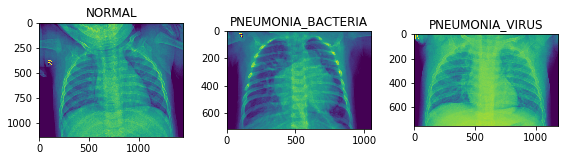

In [47]:
img_normal = plt.imread(f'{training_dir}/NORMAL/IM-0131-0001.jpeg')
img_pneumonia_bacteria = plt.imread(f'{training_dir}/PNEUMONIA/person1017_bacteria_2948.jpeg')
img_pneumonia_virus = plt.imread(f'{training_dir}/PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(8,8))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal)

plt.subplot(1,3,2).set_title('PNEUMONIA_BACTERIA')
plt.imshow(img_pneumonia_bacteria)

plt.subplot(1,3,3).set_title('PNEUMONIA_VIRUS')
plt.imshow(img_pneumonia_virus)

plt.tight_layout()

------------ CMAP=gray ----------------------- CMAP=bone


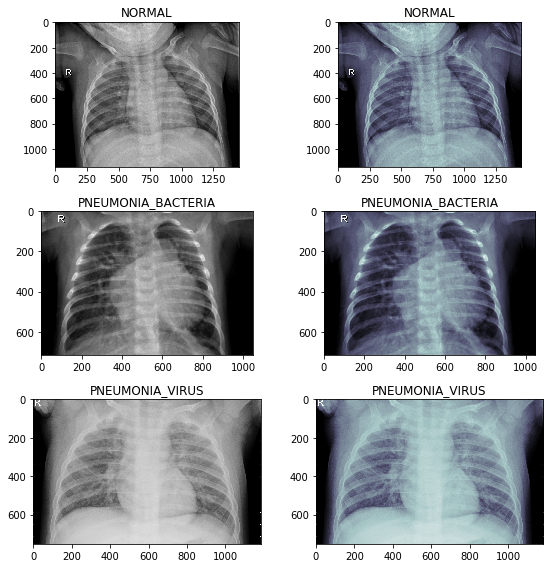

In [48]:
print("%s%s%s%s"%("-"*12, " CMAP=gray ", "-"*23, " CMAP=bone"))

plt.figure(figsize=(8,8))

plt.subplot(3,2,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')
plt.subplot(3,2,2).set_title('NORMAL')
plt.imshow(img_normal, cmap='bone')

plt.subplot(3,2,3).set_title('PNEUMONIA_BACTERIA')
plt.imshow(img_pneumonia_bacteria, cmap='gray')
plt.subplot(3,2,4).set_title('PNEUMONIA_BACTERIA')
plt.imshow(img_pneumonia_bacteria, cmap='bone')

plt.subplot(3,2,5).set_title('PNEUMONIA_VIRUS')
plt.imshow(img_pneumonia_virus, cmap='gray')
plt.subplot(3,2,6).set_title('PNEUMONIA_VIRUS')
plt.imshow(img_pneumonia_virus, cmap='bone')

plt.tight_layout()

In [76]:
# create batch iterators for the train, validation, and test data

rescale=1./255
target_size=(224,224)
batch_size=163
class_mode='categorical'
# class_mode='binary'

# creating ImageDataGenerators for training

train_datagen = ImageDataGenerator(featurewise_center=True, 
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     rescale=rescale,
                                     horizontal_flip=True)

train_generator = train_generator.flow_from_directory(training_dir,
                                                     target_size=target_size,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     seed=RANDOM_SEED,
                                                     class_mode=class_mode)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator=validation_datagen.flow_from_directory(validation_dir,
                                                        target_size=target_size,
                                                        batch_size=dir_file_count(validation_dir),
                                                        shuffle=False,
                                                        seed=RANDOM_SEED,
                                                        class_mode=class_mode)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_generator.flow_from_directory(testing_dir,
                                                   target_size=target_size,
                                                   batch_size=dir_file_count(testing_dir),
                                                   shuffle=False,
                                                   seed=RANDOM_SEED,
                                                   class_mode=class_mode)

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [77]:
# count for class instances in training data

class1_train = sum(train_iterator.classes)
class0_train = len(train_iterator.classes) - class1_train

print("Pneumonia - %i, Normal - %i" % (class0_train, class1_train))

Pneumonia - 1341, Normal - 3875


In [78]:
# count for class instances in validation data

class1_val = sum(validation_iterator.classes)
class0_val = len(validation_iterator.classes) - class1_val

print("Pneumonia - %i, Normal - %i" % (class0_val, class1_val))

Pneumonia - 121, Normal - 199


In [79]:
# count for class instances in testing data

class1_test = sum(test_iterator.classes)
class0_test = len(test_iterator.classes) - class1_test

print("Pneumonia - %i, Normal - %i" % (class0_test, class1_test))

Pneumonia - 121, Normal - 199


In [102]:
# defining category label weights as per imbalance amount of the training dataset

from sklearn.utils.class_weight import compute_class_weight

y = train_iterator.classes # vector of binary class
labels = np.unique(y) # number of classes

class_weight = compute_class_weight("balanced", labels, y)
class_weight

array([1.9448173 , 0.67303226])

# 3. Transfer Learning using the InceptionV3 pretrained CNN

## Training Files Configurations

In [0]:
main_model_dir = output_directory + r"/model/"
main_log_dir = output_directory + r"/logs/"

create_directory(main_model_dir, remove=True)
create_directory(main_log_dir, remove=True)

clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)

model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

## Callbacks

In [0]:
K.clear_session()
reset_graph()
reset_callbacks()

In [105]:
print("Setting Callbacks at ", date_time(1))

checkpoint = ModelCheckpoint(
    model_file,
    monitor='val_acc',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=1e-10,
    verbose=1)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq='batch')

callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, tensorboard]

print("Set Callbacks at ", date_time(1))

Setting Callbacks at  Timestamp: 2019-09-28 21:23:03
Set Callbacks at  Timestamp: 2019-09-28 21:23:03


### For Tensorboard

In [95]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-09-28 21:21:40--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.170.135.225, 34.237.203.145, 54.164.212.100, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.170.135.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  39.0MB/s    in 0.3s    

2019-09-28 21:21:40 (39.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [98]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://1bfb9797.ngrok.io


## Building Model

In [0]:
# Understanding the final Dense layer and the lose function for classification
# https://stackoverflow.com/questions/50808593/difference-between-dense2-and-dense1-as-the-final-layer-of-a-binary-classifi

IMG_SIZE_x = 224
IMG_SIZE_y = 224
input_shape = (IMG_SIZE_x, IMG_SIZE_y, 3)

# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    base_model.trainable = False
    x = base_model.output
    # We're going to batch normalize so that our layers can train individually much better
    x = BatchNormalization()(x)
    # Add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(rate=0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(rate=0.4)(x)
    x = Dense(128, activation = "relu")(x)
    x = Dropout(rate=0.4)(x)
    x = Dense(1, activation = "sigmoid")(x)
    # Dropout layer to reduce overfitting since our dataset is quite small
    x = Dropout(rate=0.4)(x)
    # final layer
    predictions = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.summary()
        
    return model

In [107]:
print("Getting Base Model", date_time(1))
model = get_model()
# model = get_conv_model()
# model = keras.models.load_model("data/output/models/2018-12-15 00-26-45/13-val_acc-0.70-val_loss-0.58.hdf5")

Getting Base Model Timestamp: 2019-09-28 21:23:11
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________

In [108]:
print("Starting Training Model", date_time(1))

steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)

optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs=100

model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weight)

print("Completed Model Training", date_time(1))

Starting Training Model Timestamp: 2019-09-28 21:23:19


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
32/32 - 138s - loss: 0.6886 - acc: 0.7143 - val_loss: 0.6859 - val_acc: 0.6219
Epoch 2/100
32/32 - 120s - loss: 0.6717 - acc: 0.7429 - val_loss: 0.6800 - val_acc: 0.6219
Epoch 3/100
32/32 - 123s - loss: 0.6591 - acc: 0.7429 - val_loss: 0.6750 - val_acc: 0.6219
Epoch 4/100
32/32 - 123s - loss: 0.6476 - acc: 0.7429 - val_loss: 0.6711 - val_acc: 0.6219
Epoch 5/100
32/32 - 125s - loss: 0.6374 - acc: 0.7429 - val_loss: 0.6681 - val_acc: 0.6219
Epoch 6/100
32/32 - 124s - loss: 0.6284 - acc: 0.7429 - val_loss: 0.6659 - val_acc: 0.6219
Epoch 7/100
32/32 - 122s - loss: 0.6203 - acc: 0.7429 - val_loss: 0.6644 - val_acc: 0.6219
Epoch 8/100
32/32 - 124s - loss: 0.6132 - acc: 0.7429 - val_loss: 0.6635 - val_acc: 0.6219
Epoch 9/100
32/32 - 124s - loss: 0.6070 - acc: 0.7429 - val_loss: 0.6631 - val_acc: 0.6219
Epoch 10/100
32/32 - 123s - loss: 0.6015 - acc: 0.7429 - val_loss: 0.6633 - val_acc: 0.6219
Epoch 11/100
32/32 - 123s - loss: 0.5968 - acc: 0.7429 - val_loss: 0.6638 - val_acc: 0.62

## Model Performance Visualization over the epochs

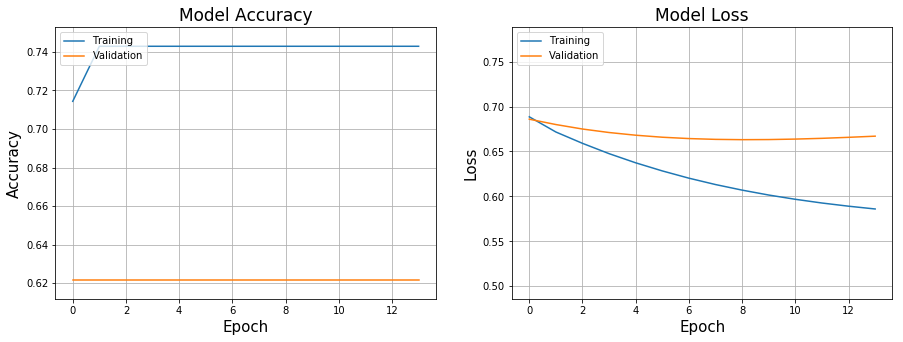

In [110]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]

plt.figure(figsize=(15,5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

## Test Saved Models

In [119]:
dir_name = r"/content/chest-xray-pneumonia/chest_xray_output/model/"
dirs = os.listdir(dir_name)
for i in range(len(dirs)):
    print(i, dirs[i])

0 2019-09-28 21-22-57


In [120]:
cur_dir =dir_name+str(dirs[0])+"/"
model_names = os.listdir(cur_dir)
for i in range(len(model_names)):
    print(i, model_names[i])

0 01-val_acc-0.62-val_loss-0.69.hdf5


In [123]:
model_file = cur_dir+model_names[0]

print(model_file)

/content/chest-xray-pneumonia/chest_xray_output/model/2019-09-28 21-22-57/01-val_acc-0.62-val_loss-0.69.hdf5


In [0]:
model = tf.keras.models.load_model(model_file)

In [126]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
1/1 [==============================] - 9s 9s/step - loss: 0.6859 - acc: 0.6219
Loss     : 0.69  
Accuracy : 62.19%


In [127]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results
1/1 [==============================] - 9s 9s/step


------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 62.19%
Recall        : 100.00%
F1-Score      : 76.69%
------------------------------------------------------------------------------------------





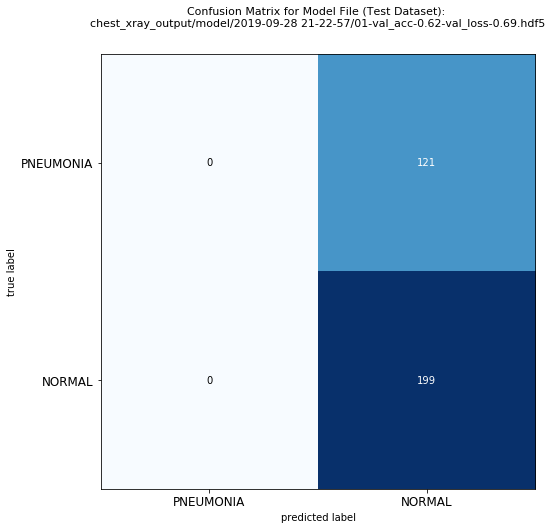




------------------------------------------------------------------------------------------
Report for Model File:  chest_xray_output/model/2019-09-28 21-22-57/01-val_acc-0.62-val_loss-0.69.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

   PNEUMONIA       0.00      0.00      0.00       121
      NORMAL       0.62      1.00      0.77       199

    accuracy                           0.62       320
   macro avg       0.31      0.50      0.38       320
weighted avg       0.39      0.62      0.48       320

------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [131]:
classes = os.listdir('/content/chest-xray-pneumonia/chest_xray/test')

image_file_name_CM = figure_directory+"/CM"

title = model_file.split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix for Model File (Test Dataset): \n"+model_title, fontsize=11)
fig.savefig(image_file_name_CM, dpi=100)
plt.show()
    

cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print("\n\n")
print("-"*90)
print("Report for Model File: ", model_title)
print("-"*90)
print(cls_report_print)
print("-"*90)

In [132]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 320
-----------------------------------
Accuracy                : 62.19%
-----------------------------------


## Visualizations

In [0]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"/"+ file_names[num], 0)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)   

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

In [0]:
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}


dpi=100


ncols = 8
# ncols = batch_size_t if batch_size_t<ncols else ncols     
# nrows = batch_size_t/ncols
# nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)
nrows = 4

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

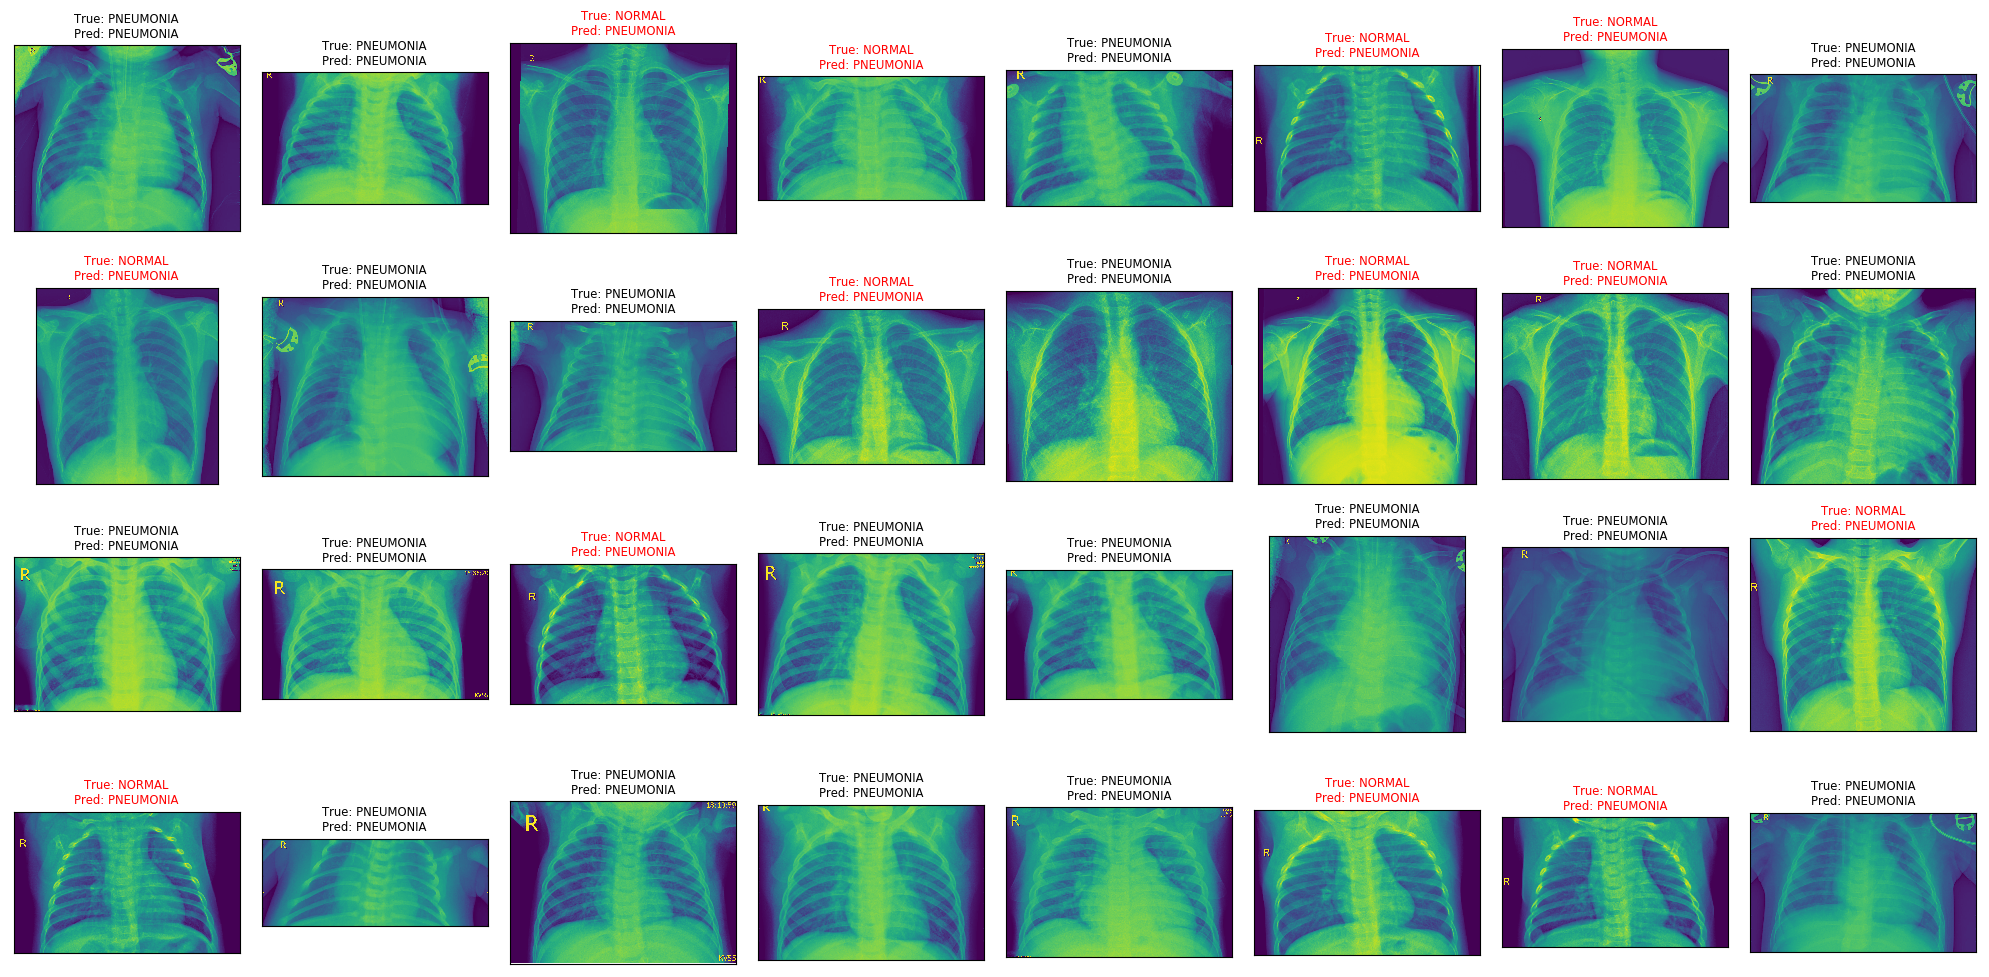

In [185]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, 
                 plot_params, class_map, testing_dir, image_file_name_batch, 
                 count=count, sample=True)


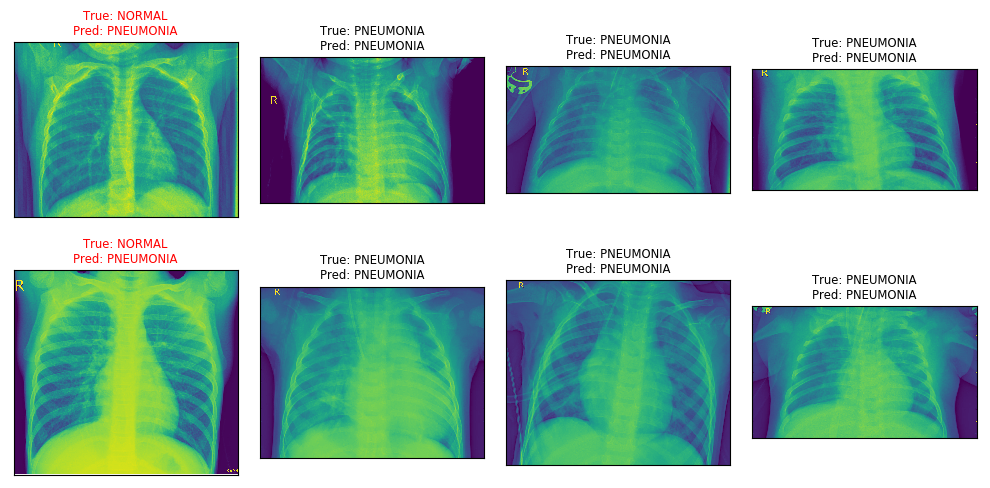

In [186]:
ncols = 4
nrows = 2

if batch_size_t<4:
    cols = 1
    
count = ncols*nrows
    

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()


show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, 
                 plot_params, class_map, testing_dir, image_file_name_sample, 
                 count=count, sample=True)